In [3]:
#imports 
import numpy as np
import h5py
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib
matplotlib.use('TkAgg')  # Set a compatible backend
import matplotlib.pyplot as plt
%matplotlib inline




In [4]:
# Dataset definition
class HeatmapTauData(Dataset):
    def __init__(self, hdf5):
        self.hdf5 = hdf5
        self.file = h5py.File(hdf5, 'r')
        self.ksz_maps = self.file["ksz_maps"]
        self.tau_values = self.file["tau_values"]
        self.num_samples = self.ksz_maps.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        heatmap = self.ksz_maps[index]
        tauval = self.tau_values[index]

        heatmap = torch.tensor(heatmap, dtype=torch.float32)
        tauval = torch.tensor(tauval, dtype=torch.float32)

        return heatmap, tauval


In [5]:
# Model definition
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.convo1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.convo2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = torch.nn.Linear(32 * 256 * 256, 128)
        self.linear2 = torch.nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.convo1(x)))
        x = self.pool2(F.relu(self.convo2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [6]:
# Dataset and Dataloaders
dataset = HeatmapTauData("all_snapshots.hdf5")

total_samples = len(dataset)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
val_loader = DataLoader(val_set, batch_size=10)
test_loader = DataLoader(test_set, batch_size=10)

In [7]:
# Training setup
blur = T.GaussianBlur(kernel_size=5, sigma=(1.0, 2.0))

model = Model()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

tau_min = dataset.tau_values[:].min()
tau_max = dataset.tau_values[:].max()

train_losses = []
val_losses = []


In [8]:
# Training loop
for epoch in range(5):
    model.train()
    train_loss = 0.0

    for heatmaps, tauvals in train_loader:
        heatmaps = heatmaps.unsqueeze(1)
        heatmaps = blur(heatmaps)

        mean = heatmaps.mean(dim=(2, 3), keepdim=True)
        std = heatmaps.std(dim=(2, 3), keepdim=True)
        heatmaps = (heatmaps - mean) / (std + 1e-8)

        tauvals = tauvals.view(-1, 1)
        tauvals = (tauvals - tau_min) / (tau_max - tau_min)
        optimizer.zero_grad()
        output = model(heatmaps)
        loss = loss_fn(output, tauvals)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss)

In [10]:
 # Validation loop
model.eval()
val_loss = 0.0
with torch.no_grad():
        for heatmaps, tauvals in val_loader:
            heatmaps = heatmaps.unsqueeze(1)
            heatmaps = blur(heatmaps)

            mean = heatmaps.mean(dim=(2, 3), keepdim=True)
            std = heatmaps.std(dim=(2, 3), keepdim=True)
            heatmaps = (heatmaps - mean) / (std + 1e-8)

            tauvals = tauvals.view(-1, 1)
            tauvals = (tauvals - tau_min) / (tau_max - tau_min)

            output = model(heatmaps)
            loss = loss_fn(output, tauvals)
            val_loss += loss.item()

val_losses.append(val_loss)
print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


Epoch 5: Train Loss = 12.9440, Val Loss = 1.8070


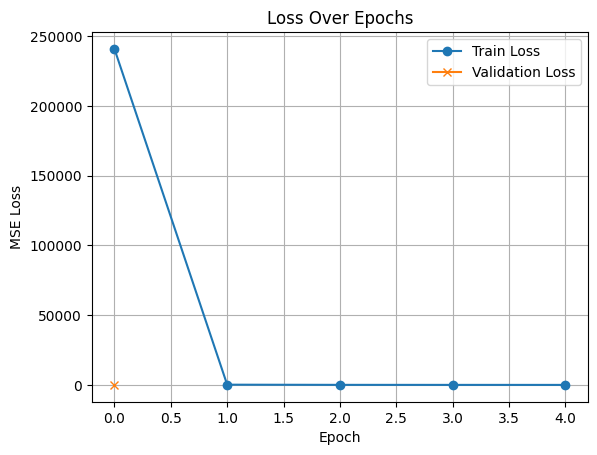

In [11]:
# Plot training and validation loss
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Test evaluation
model.eval()
test_loss = 0.0
predictions = []
targets = []

with torch.no_grad():
    for heatmaps, tauvals in test_loader:
        heatmaps = heatmaps.unsqueeze(1)
        heatmaps = blur(heatmaps)

        mean = heatmaps.mean(dim=(2, 3), keepdim=True)
        std = heatmaps.std(dim=(2, 3), keepdim=True)
        heatmaps = (heatmaps - mean) / (std + 1e-8)

        tauvals = tauvals.view(-1, 1)
        tauvals_norm = (tauvals - tau_min) / (tau_max - tau_min)

        output = model(heatmaps)
        test_loss += loss_fn(output, tauvals_norm).item()

        predictions.append(output)
        targets.append(tauvals_norm)

print(f"Final Test Loss = {test_loss:.4f}")



from sklearn.metrics import r2_score


Final Test Loss = 1.8366


In [13]:
#Convert predictions and targets to flat numpy arrays
predictions = torch.cat(predictions).squeeze().numpy()
targets = torch.cat(targets).squeeze().numpy()


In [14]:
#Compute R² Score
r2 = r2_score(targets, predictions)

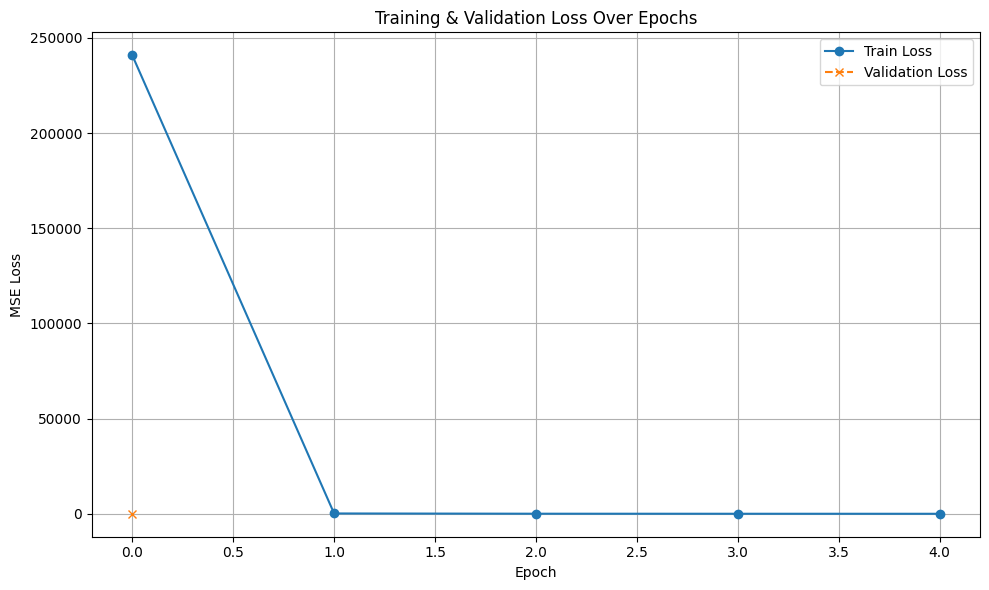

In [15]:
#enhance loss plot
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o', linestyle='-')
plt.plot(val_losses, label='Validation Loss', marker='x', linestyle='--')
plt.title("Training & Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


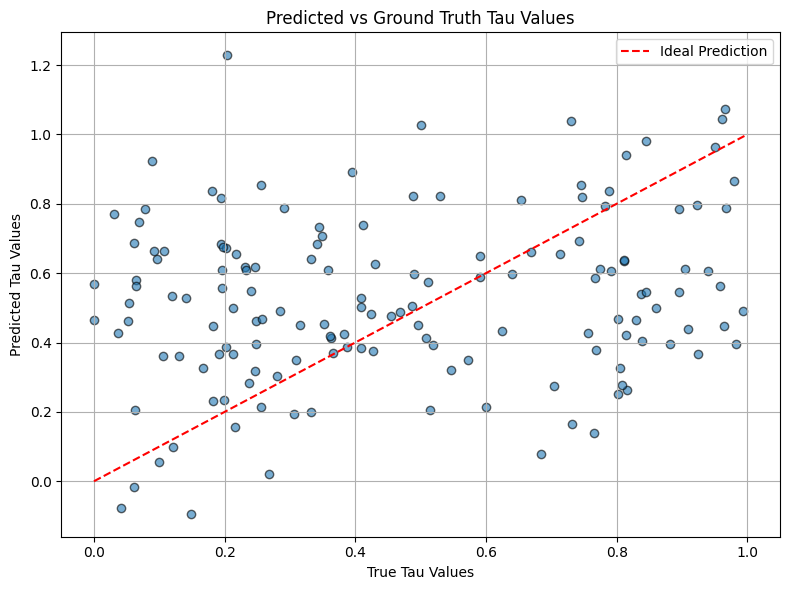

150


In [16]:
#predicction vs ground truth
plt.figure(figsize=(8, 6))
plt.scatter(targets, predictions, alpha=0.6, edgecolors='k')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Ideal Prediction')
plt.title("Predicted vs Ground Truth Tau Values")
plt.xlabel("True Tau Values")
plt.ylabel("Predicted Tau Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(len(test_set))  # or len(test_loader.dataset)



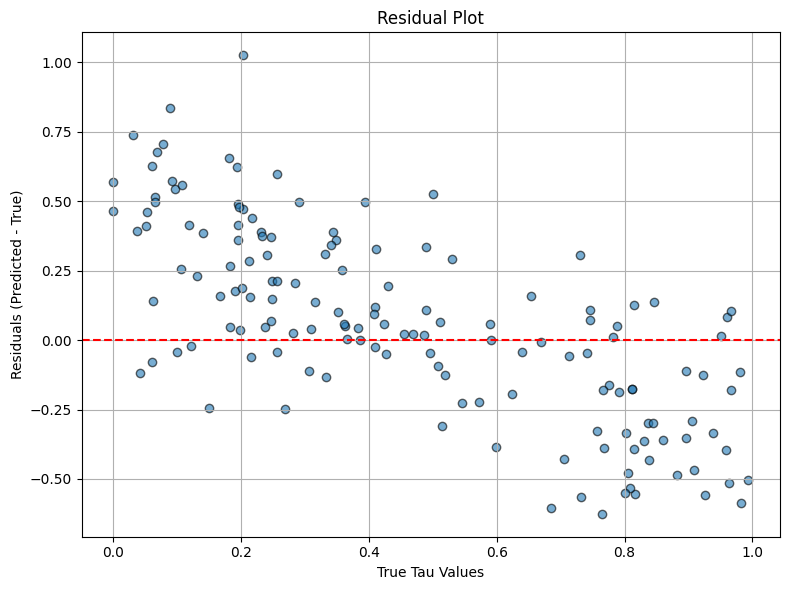

In [18]:
#plotting residuals
residuals = predictions - targets
plt.figure(figsize=(8, 6))
plt.scatter(targets, residuals, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("True Tau Values")
plt.ylabel("Residuals (Predicted - True)")
plt.grid(True)
plt.tight_layout()

plt.show()

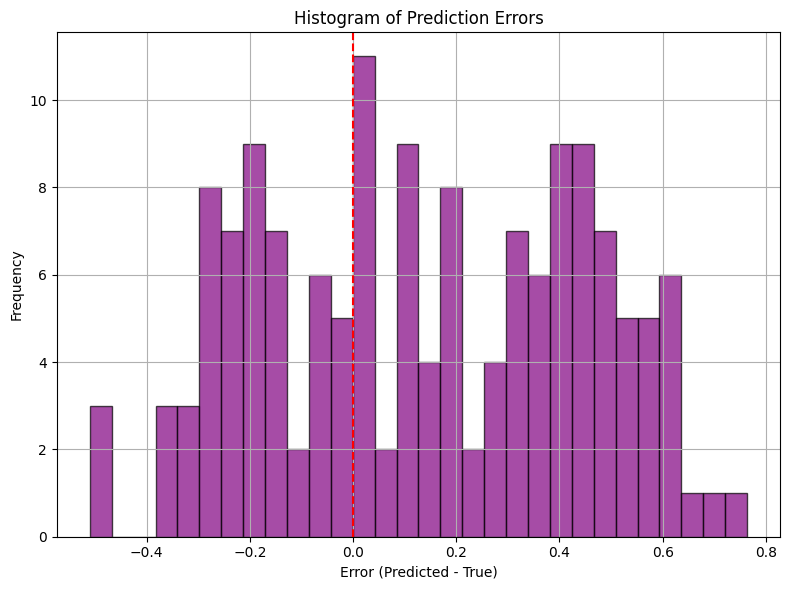

In [54]:
#a histograom for prediction
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title("Histogram of Prediction Errors")
plt.xlabel("Error (Predicted - True)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:

#r2 score
print(f"R² Score on Test Set: {r2:.4f}")


R² Score on Test Set: -0.4163


In [56]:
#dont need below 
#&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

# Use full dataset to get more predictions for plotting
full_loader = DataLoader(dataset, batch_size=10)

all_predictions = []
all_targets = []

model.eval()
with torch.no_grad():
    for heatmaps, tauvals in full_loader:
        heatmaps = heatmaps.unsqueeze(1)
        heatmaps = blur(heatmaps)

        mean = heatmaps.mean(dim=(2, 3), keepdim=True)
        std = heatmaps.std(dim=(2, 3), keepdim=True)
        heatmaps = (heatmaps - mean) / (std + 1e-8)

        tauvals = tauvals.view(-1, 1)
        tauvals_norm = (tauvals - tau_min) / (tau_max - tau_min)

        output = model(heatmaps)

        all_predictions.append(output)
        all_targets.append(tauvals_norm)

# Flatten to numpy arrays
all_predictions = torch.cat(all_predictions).squeeze().numpy()
all_targets = torch.cat(all_targets).squeeze().numpy()


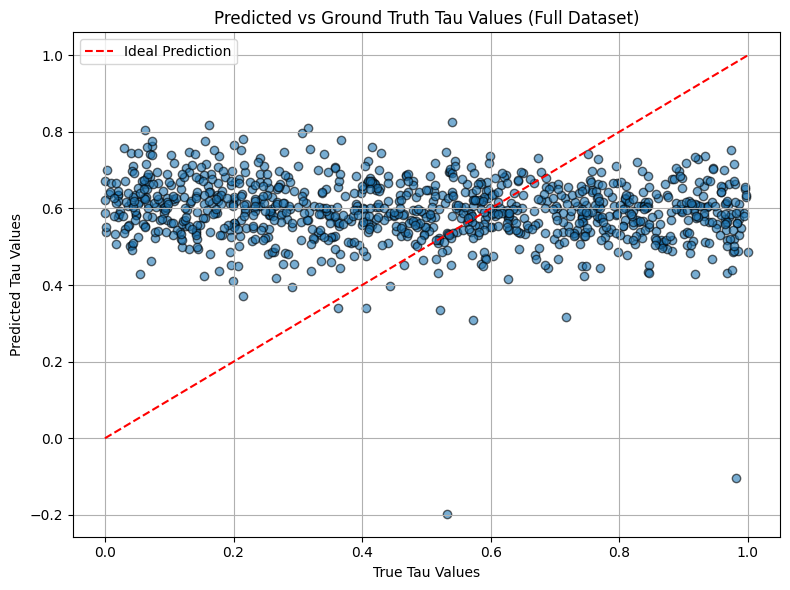

In [57]:
#predicted vs groun 
plt.figure(figsize=(8, 6))
plt.scatter(all_targets, all_predictions, alpha=0.6, edgecolors='k')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Ideal Prediction')
plt.title("Predicted vs Ground Truth Tau Values (Full Dataset)")
plt.xlabel("True Tau Values")
plt.ylabel("Predicted Tau Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


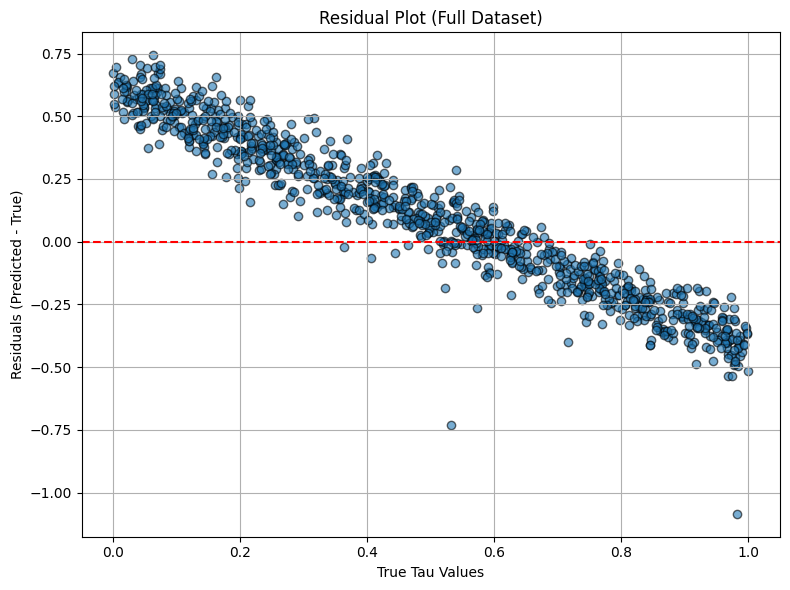

In [58]:
#residual 
residuals_all = all_predictions - all_targets
plt.figure(figsize=(8, 6))
plt.scatter(all_targets, residuals_all, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (Full Dataset)")
plt.xlabel("True Tau Values")
plt.ylabel("Residuals (Predicted - True)")
plt.grid(True)
plt.tight_layout()
plt.show()
